# Exploring the pareto front for OCC model and threshold selection

The idea:

In one-class classification we only have positive and unlabeled data for model selection. 

It is reasonable to assume that for a given true positive rate (which we can estimate from the training data) a model is the better the fewer positive predictions it returns for the unlabeled data.

It may help in a OCC application to explore the pareto front over all models and thresholds for the two conflicting goals of a high true positive rate and a low probabilty of positive predictions.

Let's get some toy data and try... 

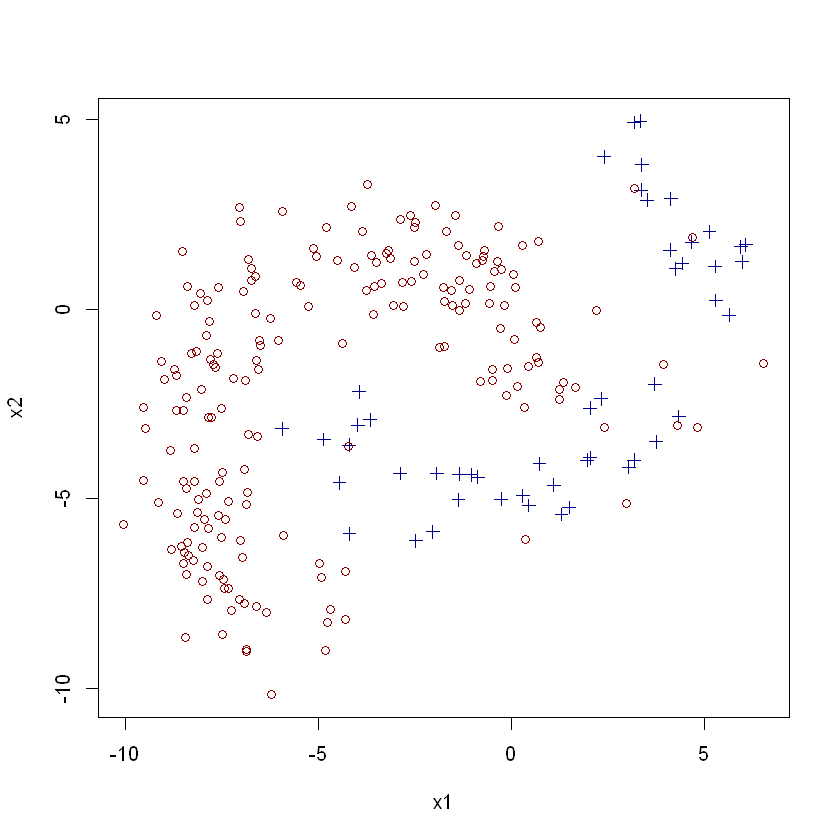

In [31]:
require(oneClass)
require(rPref)
require(dplyr)
require(doParallel)
registerDoParallel(cores=4)

data(bananas)
trs <- bananas_trainset(nP=50, nU=200)
plot(trs[, -1], pch=c(1, 3)[as.numeric(trs$y)],
     col=c("darkred", "darkblue")[as.numeric(trs$y)])

Lets get some cross-validated decision values for a couple of biased SVM models.

In [32]:
set.seed(1)
index <- createFolds(trs$y, returnTrain=T)
sapply(index, function(i) table(trs$y[i]))

,Fold01,Fold02,Fold03,Fold04,Fold05,Fold06,Fold07,Fold08,Fold09,Fold10
un,180,180,180,180,180,180,180,180,180,180
pos,45,45,45,45,45,45,45,45,45,45


In [33]:
fit <- trainOcc(x=trs[, -1], y=trs$y, index=index)

Aggregating results
Selecting tuning parameters
Fitting sigma = 1, cNeg = 32, cMultiplier = 16384 on full training set


The cross validated decision values (distances in the case of the BSVM) for all models are stored here:

In [34]:
head(fit$pred)

,pred,obs,un,pos,rowIndex,sigma,cNeg,cMultiplier,Resample
1,pos,pos,0.03074236,0.03074236,6,0.1,0.0009765625,4,Fold01
2,pos,pos,0.01761033,0.01761033,27,0.1,0.0009765625,4,Fold01
3,un,pos,-0.01319288,-0.01319288,31,0.1,0.0009765625,4,Fold01
4,un,pos,-0.01298458,-0.01298458,36,0.1,0.0009765625,4,Fold01
5,pos,pos,0.03785077,0.03785077,45,0.1,0.0009765625,4,Fold01
6,pos,un,0.01300316,0.01300316,58,0.1,0.0009765625,4,Fold01


The results based on which we usually do model selection are stored here:

In [35]:
head(fit$results)

,sigma,cNeg,cMultiplier,tpr,puP,ppp,puAuc,puF,puF1,pn,tprSD,puPSD,pppSD,puAucSD,puFSD,puF1SD,pnSD
1,0.1,0.0009765625,4,0.82,0.4597114,0.384,0.867,1.941154,0.577553,1,0.175119,0.160626,0.1018932,0.1162421,0.8428273,0.1493695,0
2,0.1,0.0009765625,16,1,0.2,1,0.907,1,0.3333333,0,0,0,0,0.08769265,0,0,0
3,0.1,0.0009765625,64,1,0.2,1,0.892,1,0.3333333,0,0,0,0,0.09647107,0,0,0
4,0.1,0.0009765625,256,1,0.2,1,0.917,1,0.3333333,0,0,0,0,0.125614,0,0,0
5,0.1,0.0009765625,1024,1,0.2,1,0.917,1,0.3333333,0,0,0,0,0.125614,0,0,0
6,0.1,0.0009765625,4096,1,0.2,1,0.917,1,0.3333333,0,0,0,0,0.125614,0,0,0


But the performance metrics, e.g. puF, are only evaluated at the separating hyperplane, i.e. at 0.
We might want to consider other threshold and calclate the true positive rate (tpr) and the probability of positive predictions (ppp) over all models and a lot of thresholds (by default 50 in the range of the returned decision values):

In [36]:
params <- fit$modelInfo$parameters$parameter
idx <- group_indices_(
  fit$pred, 
  .dots=as.character(params))
u_idx <- sort(unique(idx))

We want to keep the model position according to the `fit` and can do it like this:

In [37]:
res <- foreach(i = u_idx, .packages="oneClass") %dopar% {
    df <- fit$pred[idx==i, ]
    modrow = modelPosition(fit, modParam=df[1, as.character(params)])$row
    cbind(modrow=modrow, puSummaryThLoop(df, returnAll=TRUE))
}
res <- do.call(rbind, res)
head(res)

,modrow,th,tpr,puP,ppp,puF,puF1,pn
1,1,-0.03546184,1,0.2380952,0.84,1.190476,0.3846154,1
2,1,-0.03396287,1,0.25,0.8,1.25,0.4,1
3,1,-0.0324639,1,0.2631579,0.76,1.315789,0.4166667,1
4,1,-0.03096493,1,0.2762431,0.724,1.381215,0.4329004,1
5,1,-0.02946597,1,0.2890173,0.692,1.445087,0.4484305,1
6,1,-0.027967,0.98,0.2969697,0.66,1.455152,0.455814,1


Now we do not only have the metrics at one but 50 thresholds per model. 
Which makes 12600 possible model / threshold candidates.

In [38]:
nrow(res)

[1] 12600

How should we select a solution knowing that we should use puF and similar metrics with caution?
First we can see if we can reduce the number of solutions by using the non-dominated solutions, i.e. the solutions on the pareto-front. 
These turn out to be less: 

In [39]:
get_nondominated_solutions <- function(x, rm_duplicated=TRUE, verbose=TRUE) {
    nondominated <- psel(x, high(tpr) * low(ppp)) 
    # There are lots of duplicates with equal tpr and ppp values which we remove
    n_all <- nrow(nondominated)
    nondominated <- nondominated[!duplicated(nondominated[, c("tpr", "ppp")]), ]
    n_no_duplicates <- nrow(nondominated)
    nondominated <- nondominated[order(-nondominated$tpr, nondominated$ppp), ]
    if (verbose)
        cat(sprintf("Solutions with / without duplicated: %d / %d", n_all, n_no_duplicates))
    return(nondominated) # now ordered by descending tpr   
}

In [40]:
nondominated <- get_nondominated_solutions(res)

Solutions with / without duplicated: 472 / 33

And we only have a low fraction of models in which the nondominated solutions live in.

In [41]:
nondominated_models <- nondominated$modrow
nrow(fit$results)
length(unique(nondominated$modrow))

[1] 252

[1] 20

The following plot shows all solutions (no color), the solutions at the pareto front (blue), the solutions at th=0 (red) and the selected model among th=0 solutions (green):

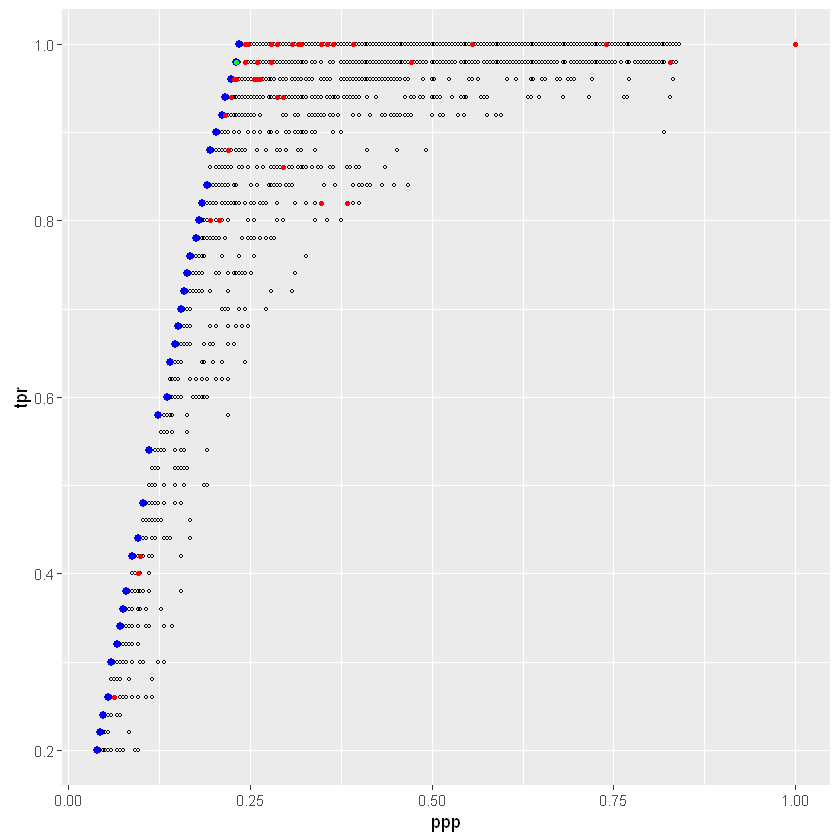

In [42]:
ggplot(res, aes(x = ppp, y = tpr)) + 
  geom_point(shape = 21, size=.75) + 
  geom_point(data=nondominated, size = 2, col="blue") +
  geom_point(data=fit$results, size = 1, col="red") + 
  geom_point(data=fit$results[modelPosition(fit)$row, , drop=F], size = 1, col="green")

And how is that useful?

1) Automatic model selection with whatever PU-based optimization might benefit by considering only the non-dominated solutions since this might reduce the risk.

2) We can investigate if a subset of models contains a similar pareto front.

3) If we manually analyze different models, e.g. by plotting the histograms, it reduces the models to be investivated to a reasonable size.

For example 2): 

Let us compare the non-dominant solutions of all models and thresholds given a fixed `cMultplier`.
The result is interesting! If we search our best solution among all the thresholds (and not only th=0 as is usually done) we can forget fitting models for different `cMultiplier` values and thus we need to fit a much smaller amount of models. In our case:

In [43]:
nValues <- sapply(c("sigma", "cNeg", "cMultiplier"), function(p) length(unique(fit$results[, p])))
cat(sprintf("# all models / # models given fixed cMultiplier: %d / %d", prod(nValues[1:2]), prod(nValues)))

# all models / # models given fixed cMultiplier: 36 / 252

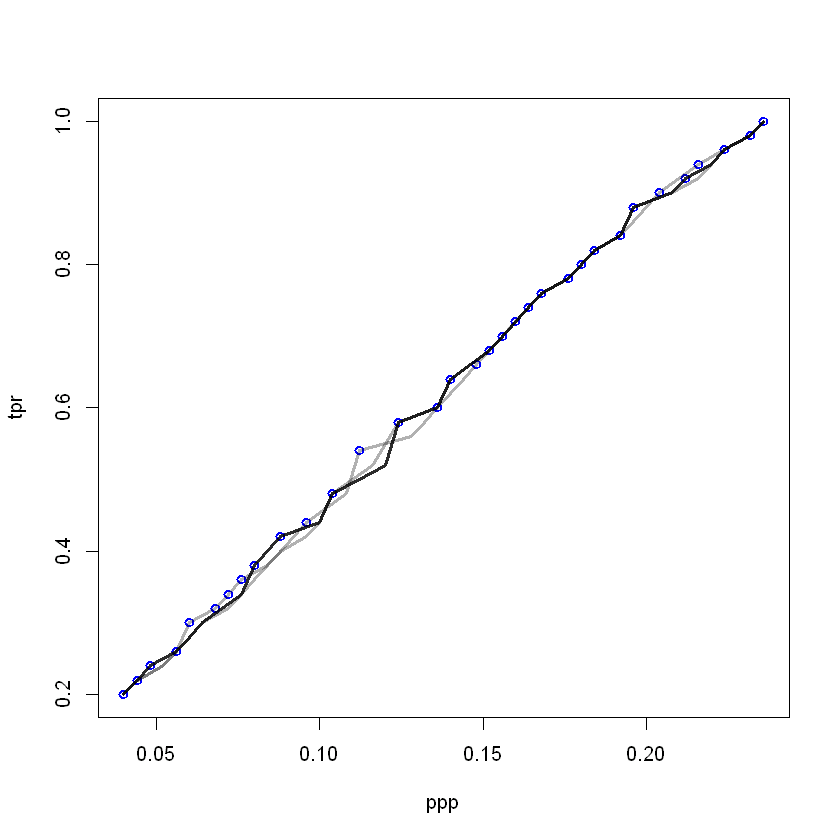

In [49]:
cMultipliers <- sort(unique(fit$results$cMultiplier))
nondominated_cM <- lapply(cMultipliers, function(cM) 
    get_nondominated_solutions(res[res$modrow %in% which(fit$results$cMultiplier==cM), ], verbose=F))
plot(nondominated$ppp, nondominated$tpr, xlab="ppp", ylab="tpr", col="blue", lwd=2)
for (ele in nondominated_cM)
    lines(ele$ppp, ele$tpr, xlab="ppp", ylab="tpr", col=rgb(0, 0, 0, alpha=.3), lwd=3)

For example 3):

Is the selected th=0 solution one of the models with nondominated solutions? 

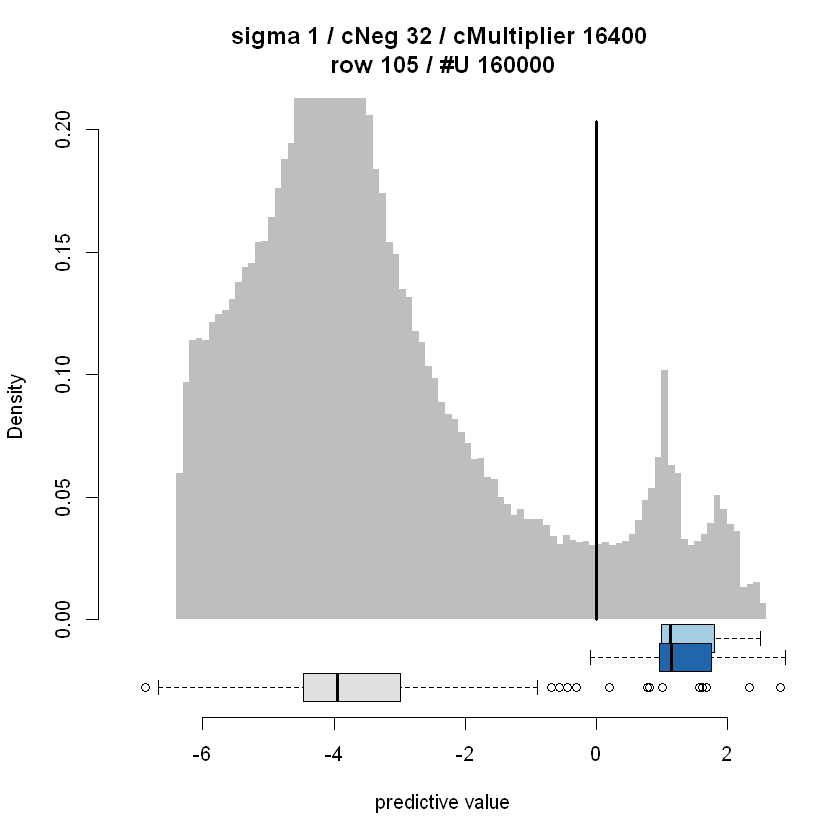

In [45]:
hist(fit, predict(fit, bananas$x[]), th=0)

In [46]:
unique(nondominated$modrow)
modelPosition(fit)$row  %in% unique(nondominated$modrow)

[1]  99  57  73  58 135 148 155 141 127  51  78  66  80  79  30  37  65  38 176
[20]  23

[1] FALSE

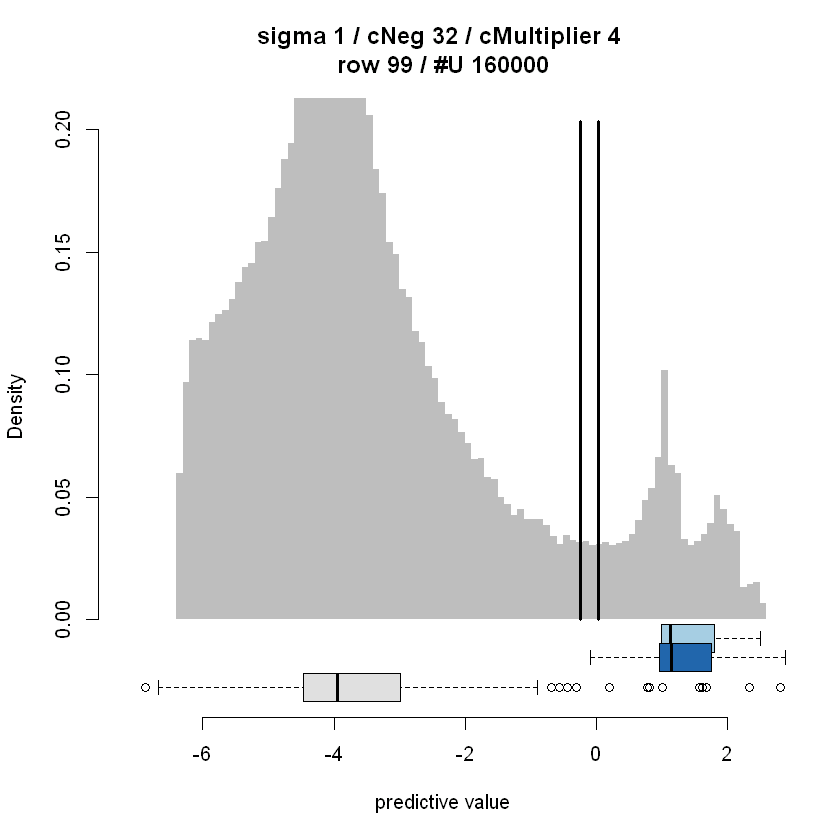

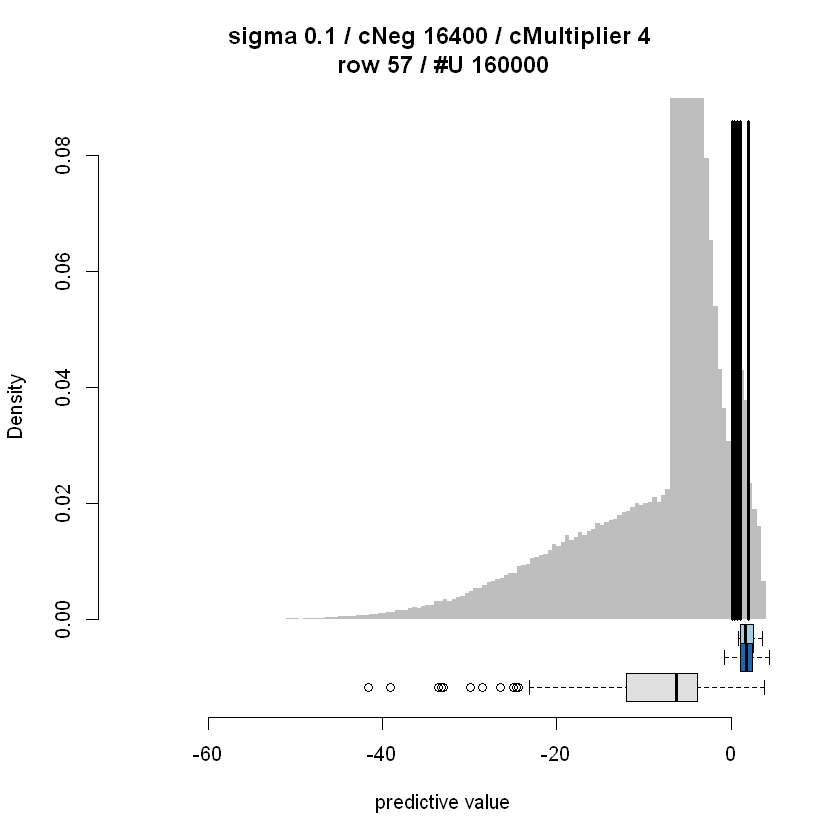

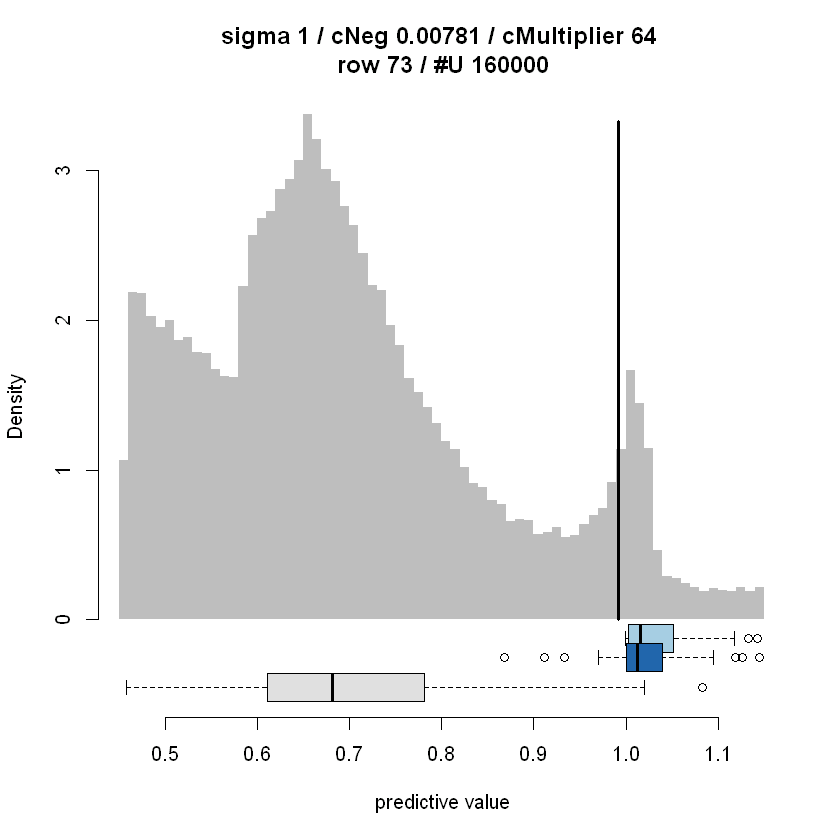

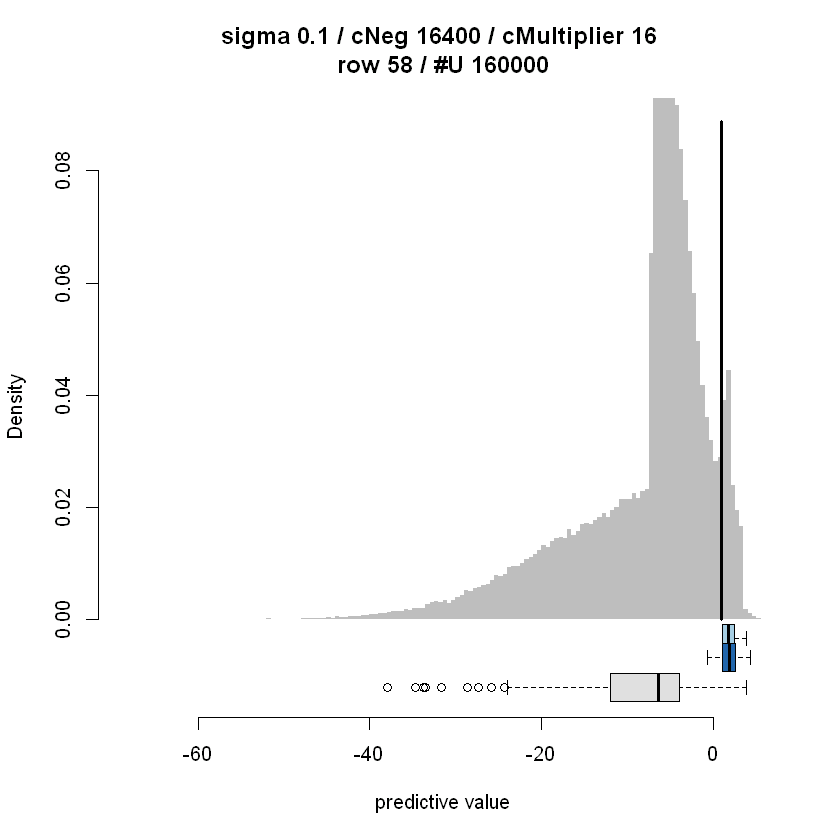

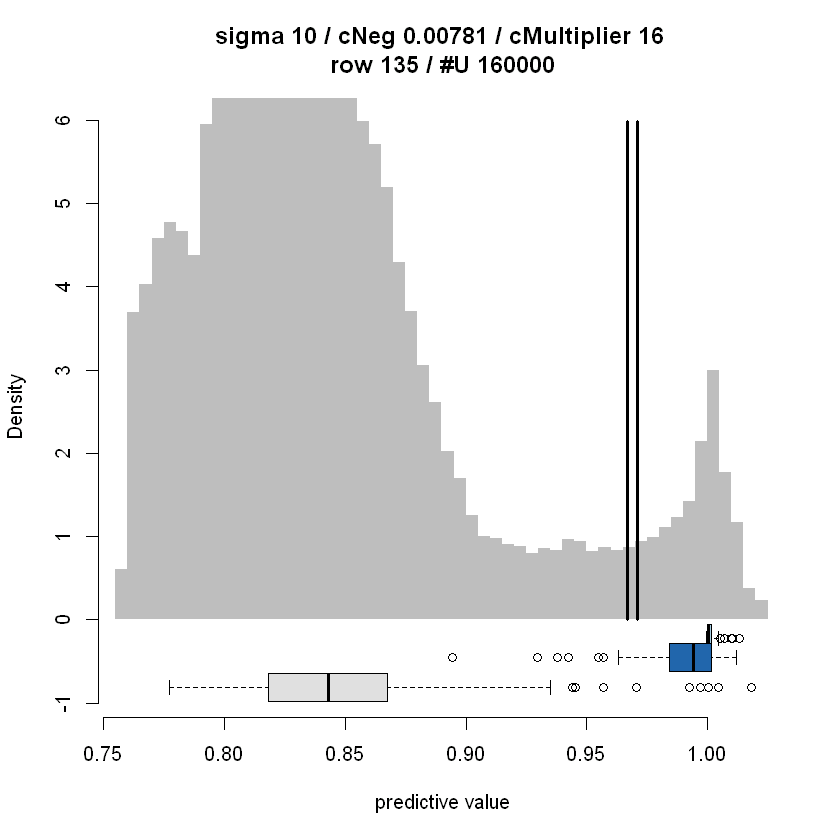

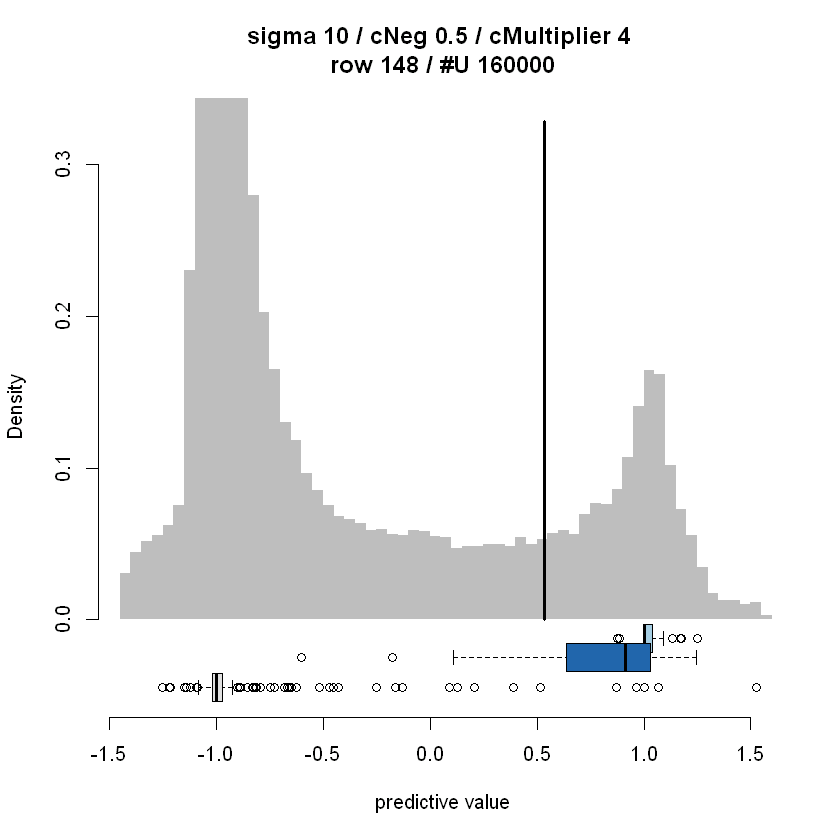

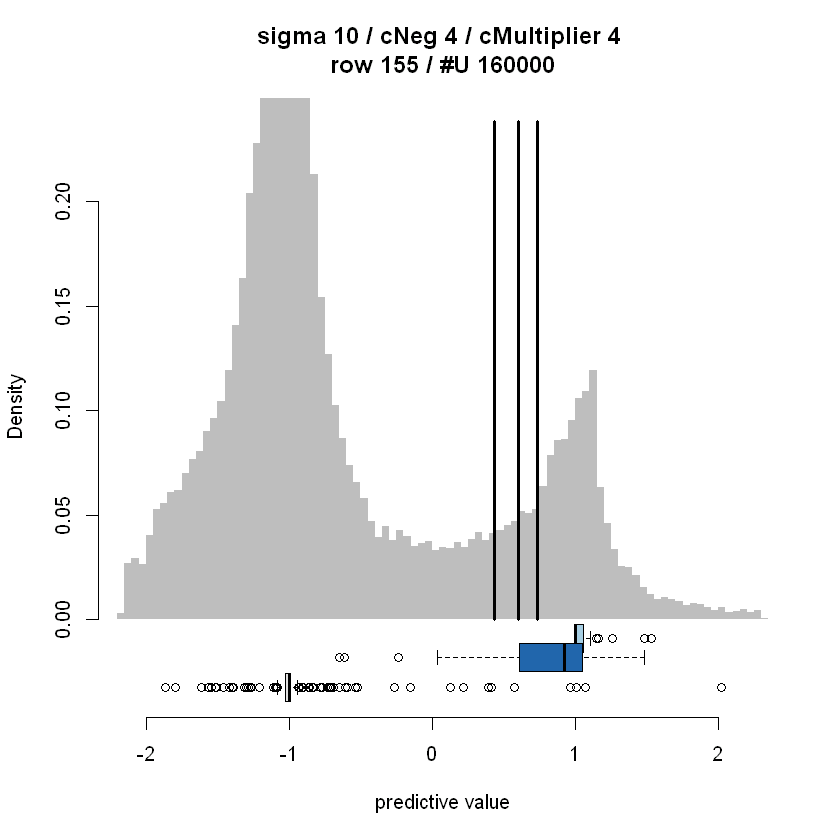

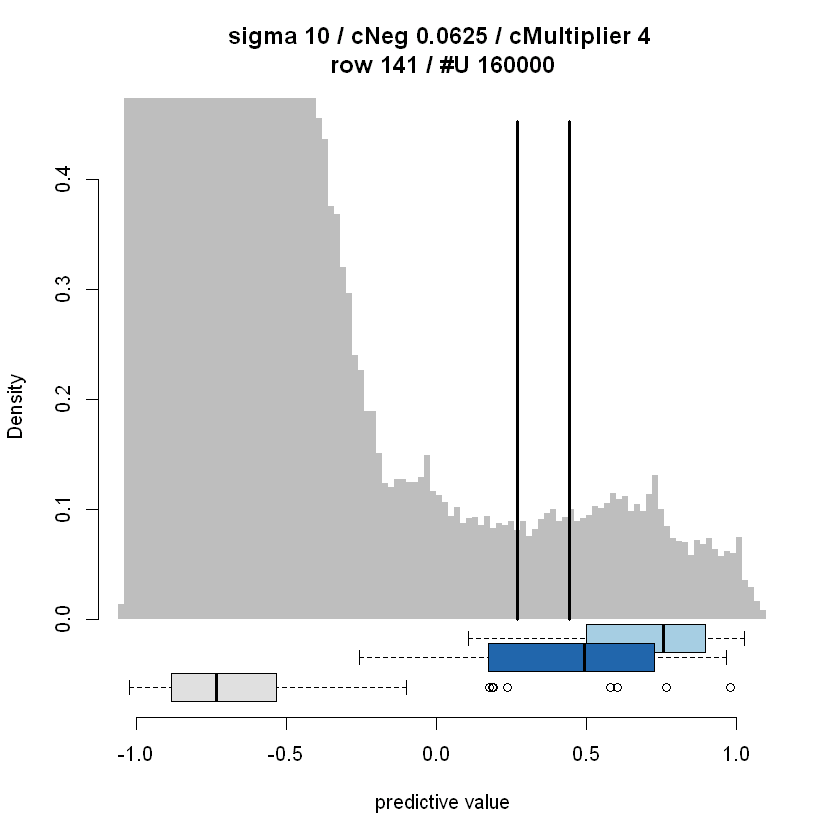

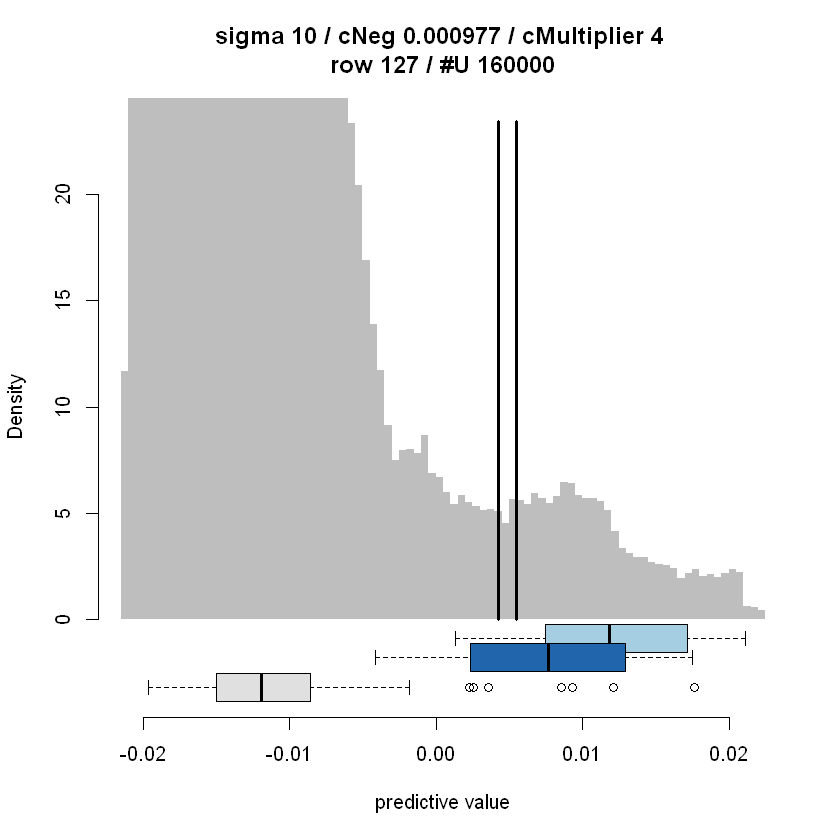

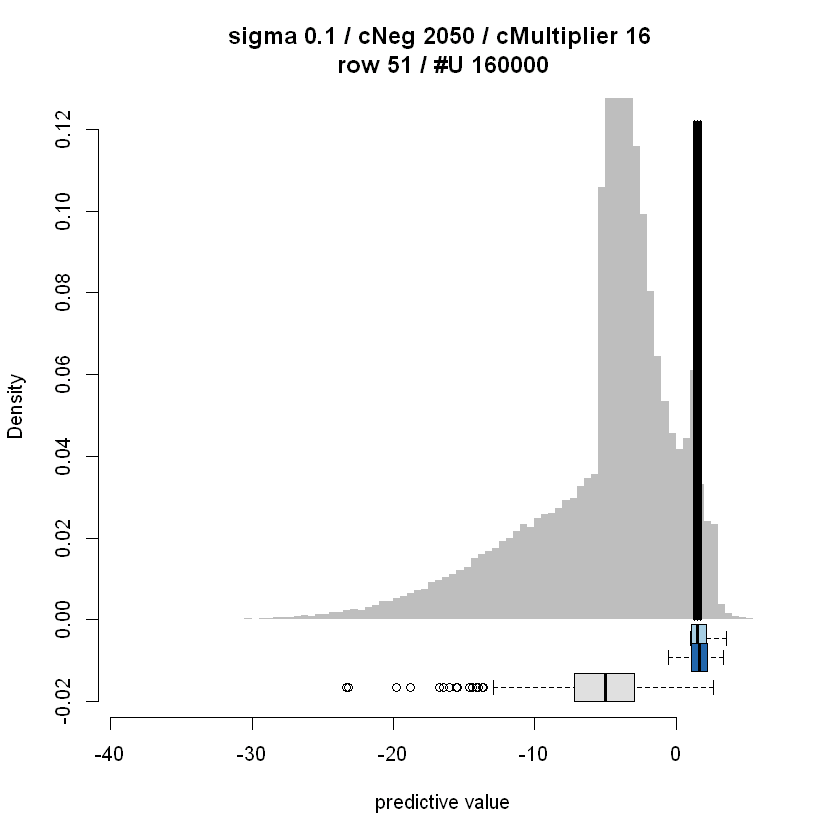

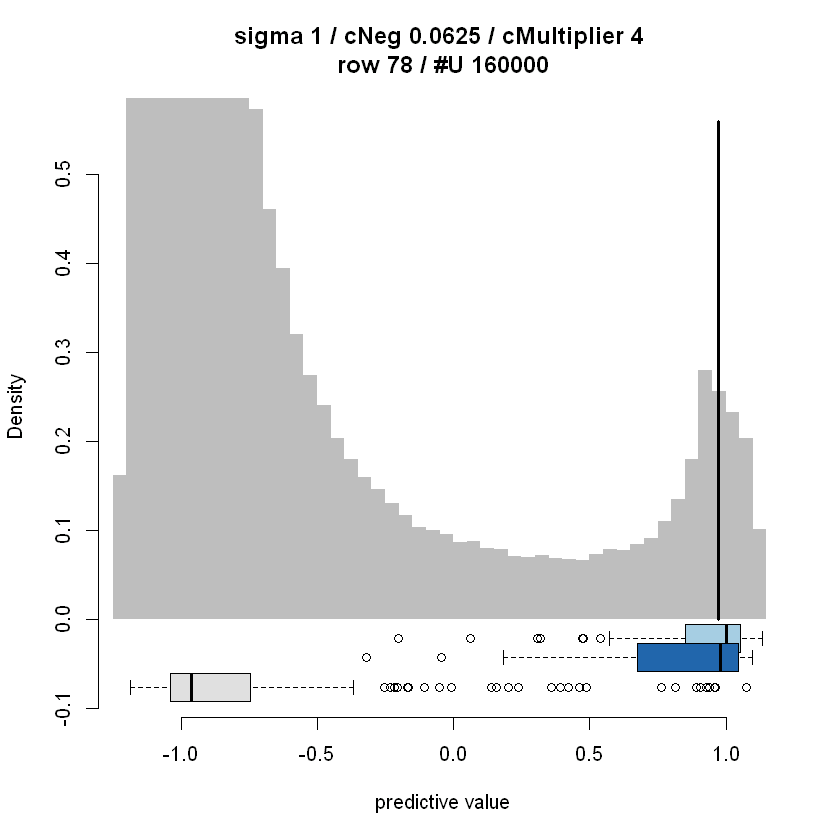

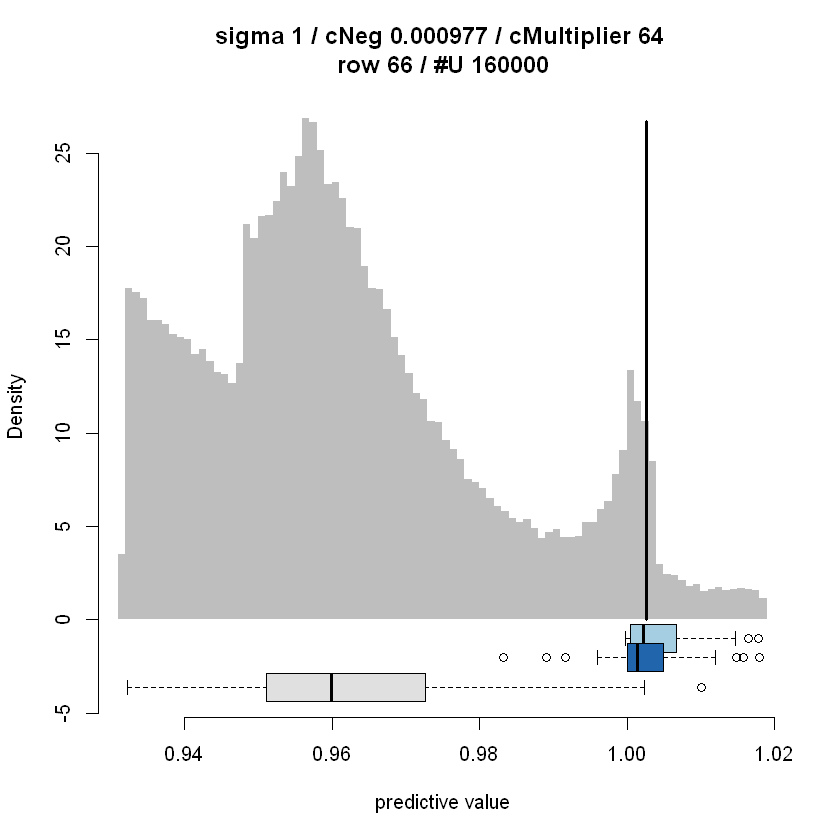

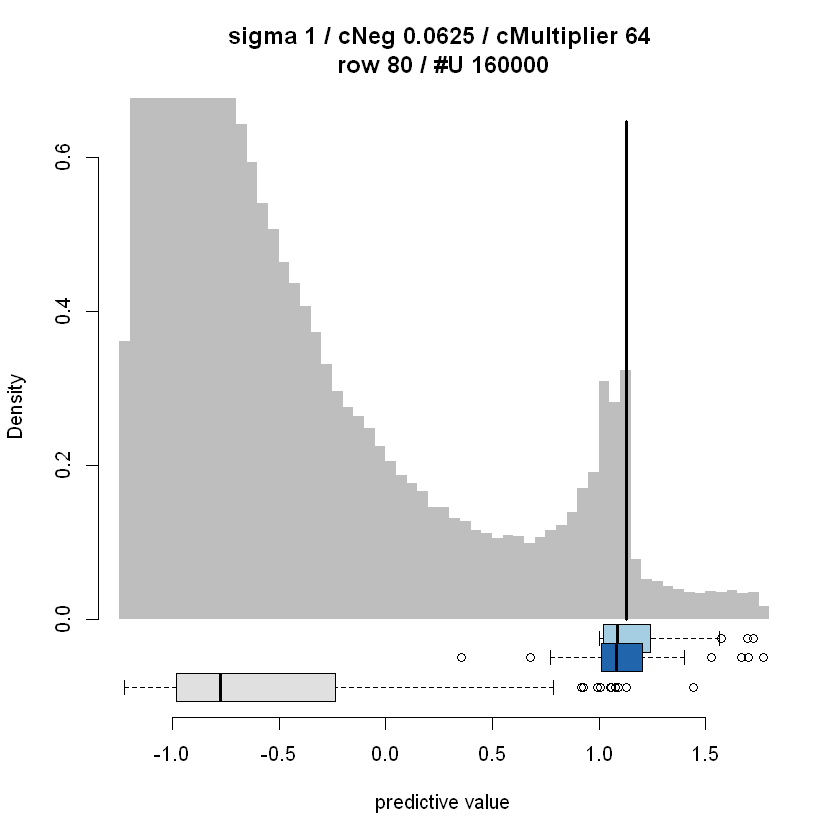

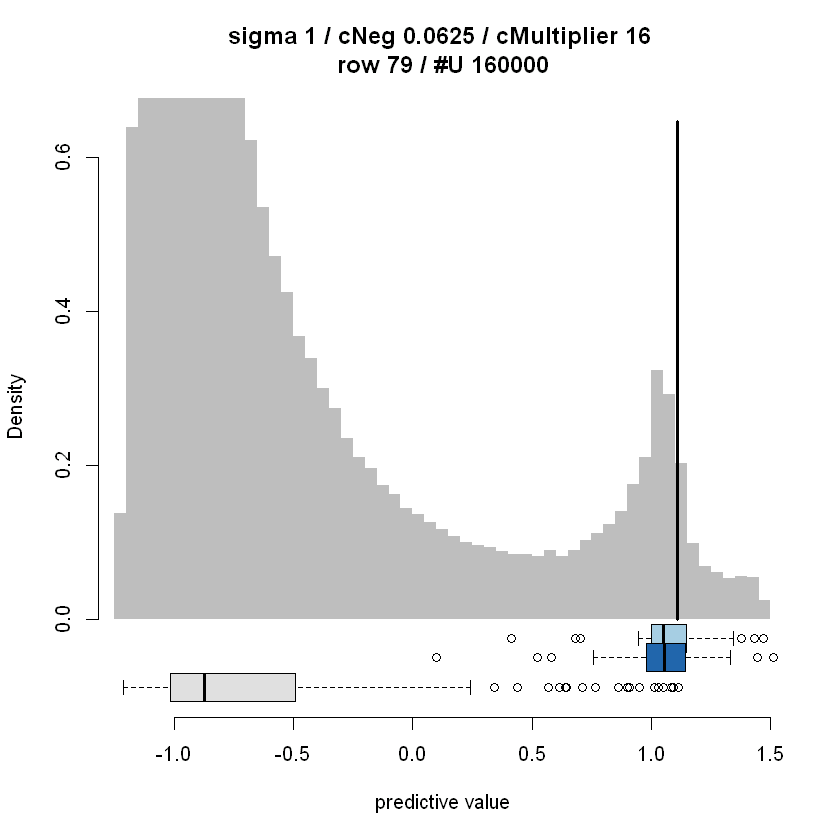

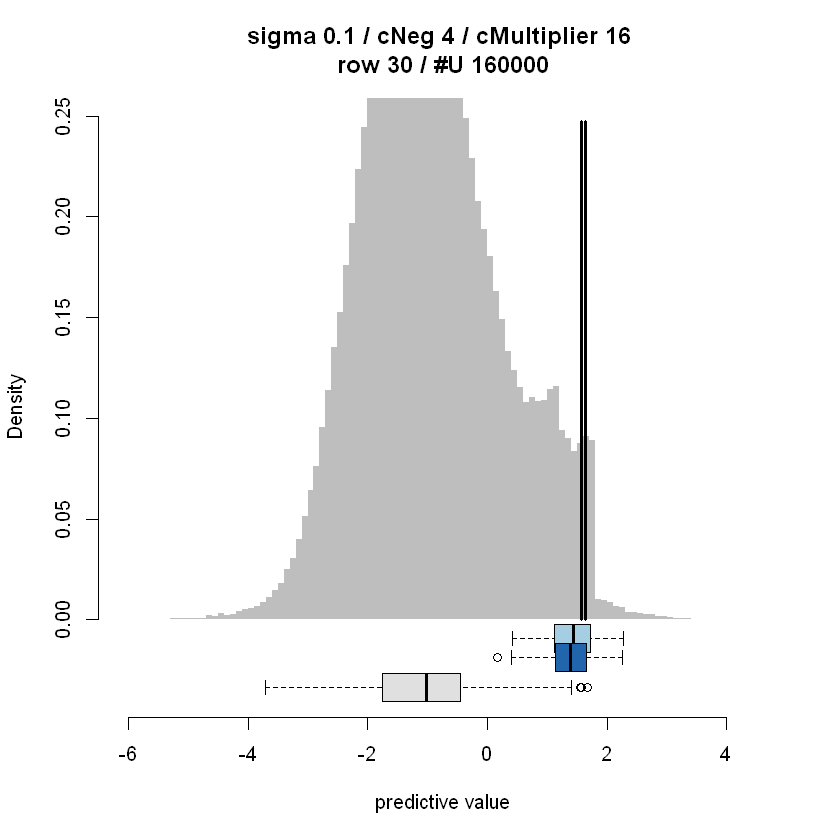

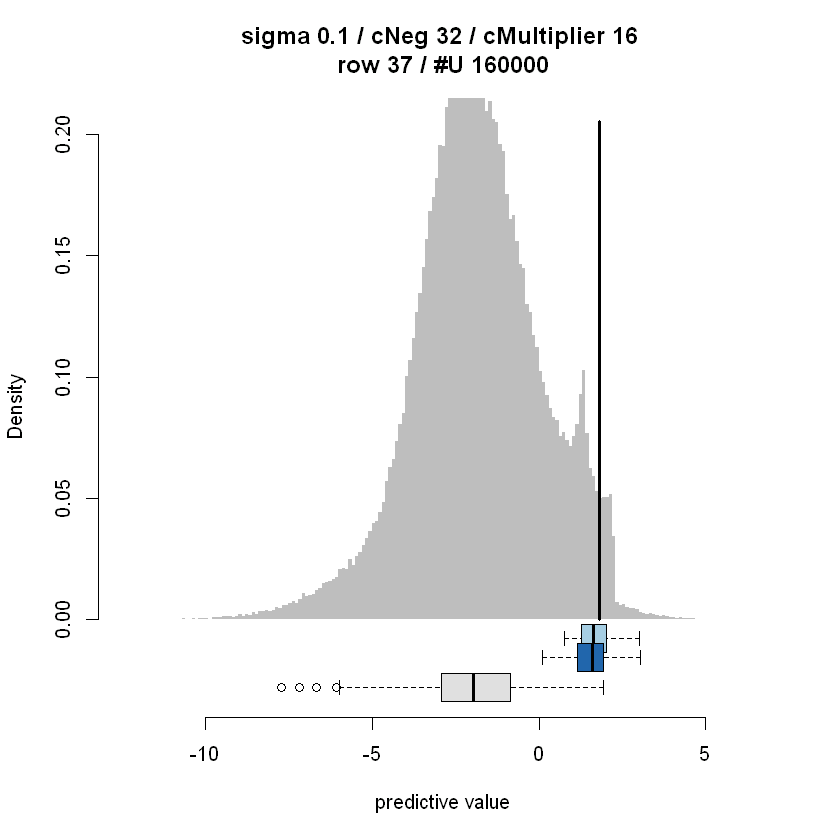

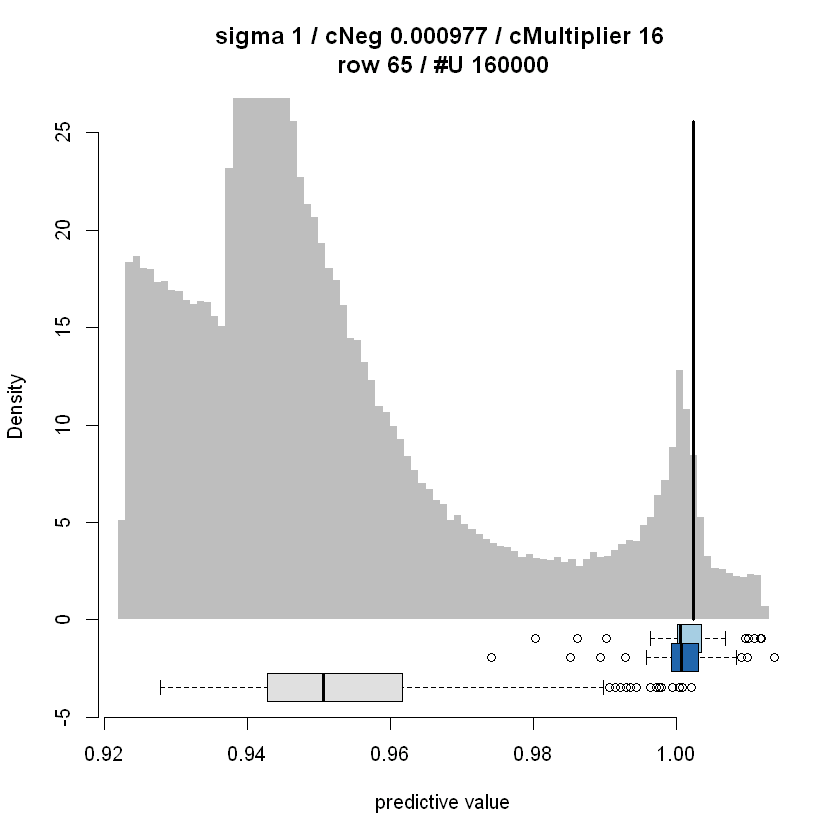

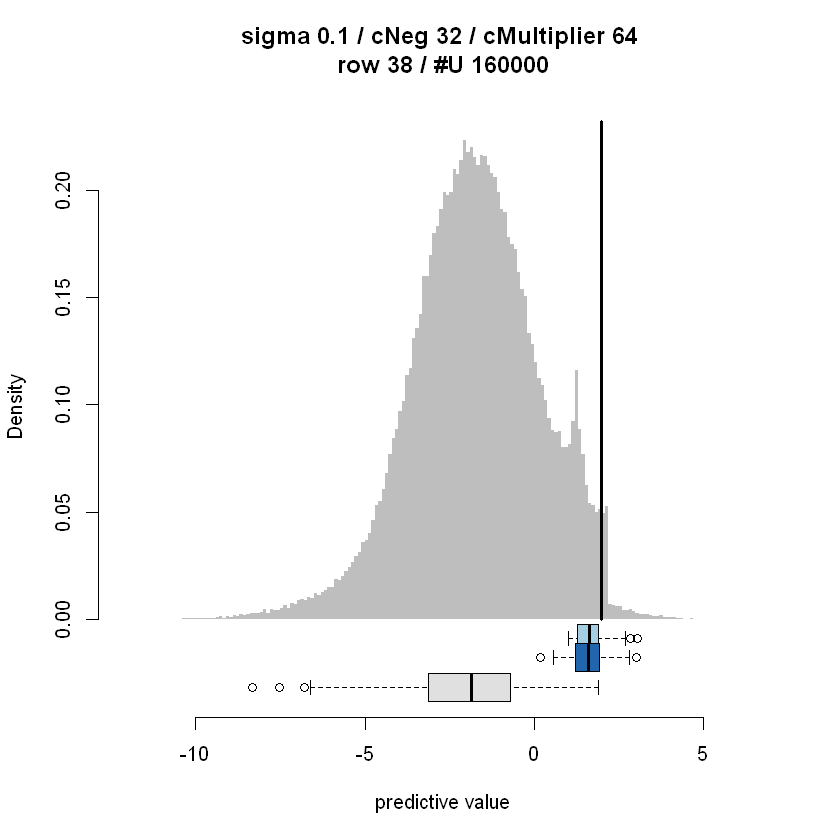

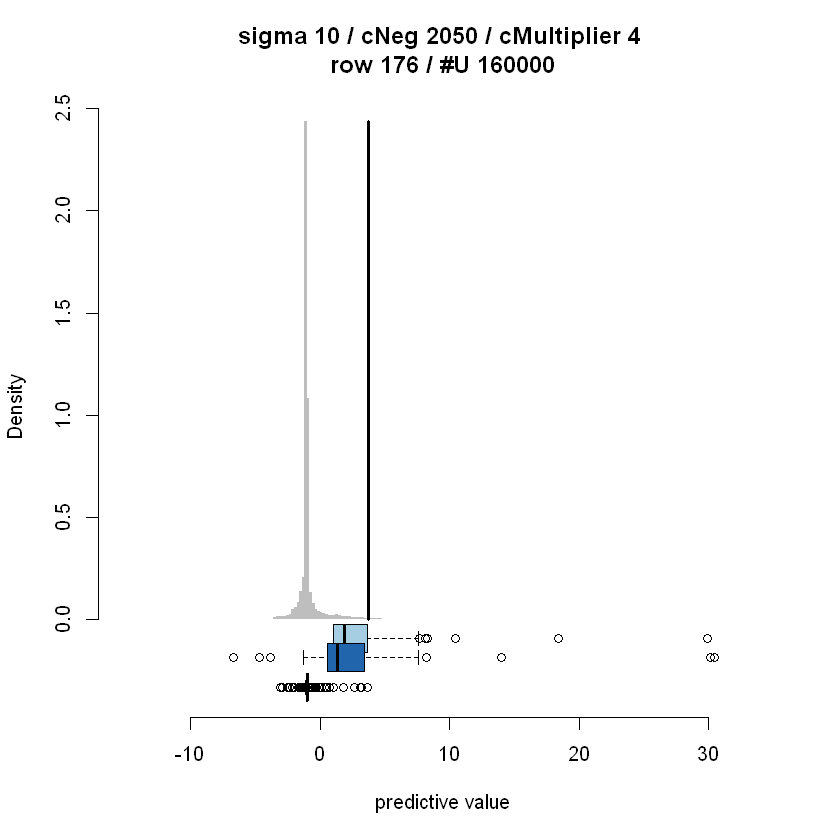

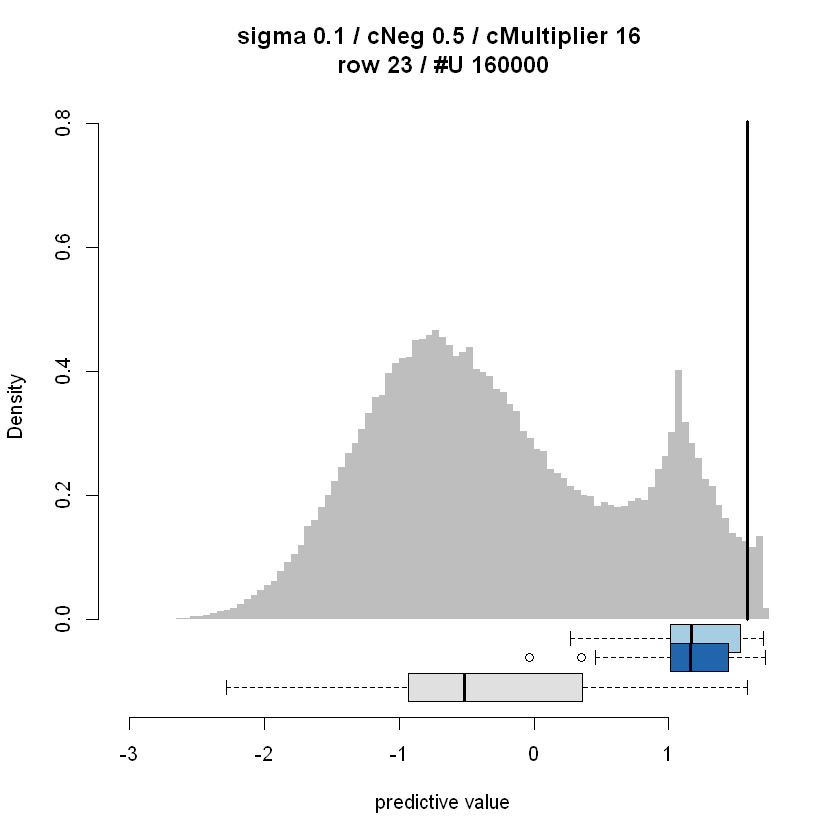

In [47]:
for (mr in unique(nondominated$modrow)) {
    fit <- update(fit, modRow = mr)
    hist(fit, predict(fit, bananas$x[]), th=nondominated$th[nondominated$modrow==mr])
}

What to choose?